In [1]:
import copy
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt

import sys
sys.path.append("..")

from mapper.geometry import from_twist, to_twist

In [2]:
camera_matrix = pickle.load(open("../camera_calibration/parameters/ir/camera_matrix.pkl", "rb"))

In [3]:
pose_graph = pickle.load(open("pose_graph.pkl", "rb"))
map_points = pickle.load(open("map_points.pkl", "rb"))
last_pts = pickle.load(open("last_pts.pkl", "rb"))
current_pts = pickle.load(open("current_pts.pkl", "rb"))
matches_query_idxs = list(pickle.load(open("matches_query_idxs.pkl", "rb")))
current_kp = pickle.load(open("current_kp.pkl", "rb"))
current_kp = cv2.KeyPoint_convert(current_kp.reshape(-1, 1, 2))
current_des = pickle.load(open("current_des.pkl", "rb"))
frame = pickle.load(open("frame.pkl", "rb"))
frame_name = pickle.load(open("frame_name.pkl", "rb"))

In [4]:
def triangulate_map_points(last_pts, current_pts, R1, t1, R2, t2, camera_matrix):
    """Triangulate 3D map points from corresponding points in two
    keyframes. R1, t1, R2, t2 are the rotation and translation of
    the two key frames w.r.t. to the map origin.
    """
    # create projection matrices needed for triangulation of 3D points
    proj_matrix1 = np.hstack([R1.T, -R1.T.dot(t1)])
    proj_matrix2 = np.hstack([R2.T, -R2.T.dot(t2)])
    proj_matrix1 = camera_matrix.dot(proj_matrix1)
    proj_matrix2 = camera_matrix.dot(proj_matrix2)

    # triangulate new map points based on matches with previous key frame
    pts_3d = cv2.triangulatePoints(proj_matrix1, proj_matrix2, last_pts.reshape(-1, 2).T, current_pts.reshape(-1, 2).T).T
    pts_3d = cv2.convertPointsFromHomogeneous(pts_3d).reshape(-1, 3)
    return pts_3d

In [5]:
def get_map_points_and_kps_for_matches(map_points, last_kf_index, matches_query_idxs):
    """Returns map points and corresponding key points for current frame.

    Given matches between a current frame and the last keyframe the function
    finds which key point in the current frame correpsonds to which key point
    in the last key frame and returns the map points corresponding to these
    key points. It also returns the indices in the `matches` array corresponding
    to the returned 3D points.
    """
    # get all map points observed in last KF
    _, pts_3d, associated_kp_indices, _ = map_points.get_by_observation(last_kf_index)
    # get indices of map points which were found again in the current frame
    kp_idxs = []
    match_idxs = []
    for match_idx, matches_query_idx in enumerate(matches_query_idxs):
        try:
            kp_idx = associated_kp_indices.index(matches_query_idx)
        except ValueError:
            pass
        else:
            kp_idxs.append(kp_idx)
            match_idxs.append(match_idx)
    print(("{} of {} ({:3.3f} %) keypoints in last key frame have been "
          "found again in current frame").format(len(match_idxs),
          len(matches_query_idxs), len(match_idxs)/len(matches_query_idxs)))
    # get map points according to the indices
    pts_3d = pts_3d[np.array(kp_idxs), :]
    return pts_3d, np.array(match_idxs)

In [6]:
def estimate_camera_pose(last_pts, current_pts, camera_matrix, min_inliers=20):
    """Estimate camera pose relative to last key frame by decomposing essential
    matrix computed from 2D-2D point correspondences in the current frame and
    last key frame.
    """
    # Note: tranlation t is only known up to scale
    essential_mat, mask = cv2.findEssentialMat(last_pts.reshape(1, -1, 2), current_pts.reshape(1, -1, 2), camera_matrix, method=cv2.LMEDS)
    num_inliers, R, t, mask = cv2.recoverPose(essential_mat, last_pts.reshape(1, -1, 2), current_pts.reshape(1, -1, 2), camera_matrix, mask=mask)
    mask = mask.astype(np.bool).reshape(-1,)
    print("recover pose num inliers: ", num_inliers)

    if num_inliers < min_inliers:
        raise RuntimeError("Could not recover camera pose.")
    return R, t, mask

In [7]:
# get all four possible solutions of decomposing the essential matrix
essential_mat, mask = cv2.findEssentialMat(last_pts.reshape(1, -1, 2), current_pts.reshape(1, -1, 2), camera_matrix, method=cv2.LMEDS)
R1, R2, t = cv2.decomposeEssentialMat(essential_mat)
print(R1, "\n", t)
print(R1, "\n", -t)
print(R2, "\n", t)
print(R2, "\n", -t)

solutions = [
    [R1,  t],
    [R1, -t],
    [R2,  t],
    [R2, -t],
]

solutions = copy.deepcopy(solutions)

[[ 9.99912290e-01  8.02056307e-04 -1.32200575e-02]
 [-7.96665880e-04  9.99999597e-01  4.13007305e-04]
 [ 1.32203834e-02 -4.02439111e-04  9.99912526e-01]] 
 [[-0.99879593]
 [-0.01785243]
 [-0.04569434]]
[[ 9.99912290e-01  8.02056307e-04 -1.32200575e-02]
 [-7.96665880e-04  9.99999597e-01  4.13007305e-04]
 [ 1.32203834e-02 -4.02439111e-04  9.99912526e-01]] 
 [[0.99879593]
 [0.01785243]
 [0.04569434]]
[[ 9.96277676e-01  3.64233065e-02  7.81289594e-02]
 [ 3.64764586e-02 -9.99334233e-01  7.47170937e-04]
 [ 7.81041582e-02  2.10547803e-03 -9.96942981e-01]] 
 [[-0.99879593]
 [-0.01785243]
 [-0.04569434]]
[[ 9.96277676e-01  3.64233065e-02  7.81289594e-02]
 [ 3.64764586e-02 -9.99334233e-01  7.47170937e-04]
 [ 7.81041582e-02  2.10547803e-03 -9.96942981e-01]] 
 [[0.99879593]
 [0.01785243]
 [0.04569434]]


In [8]:
reprojection_errors = []
num_positive_depth = []
pts_3ds = []
R_currents = []
t_currents = []


for R, t in solutions:
    print(R, t)

    prev_node_id = sorted(pose_graph.nodes)[-1]
    R_last, t_last = from_twist(pose_graph.nodes[prev_node_id]["pose"])
    R_current = np.matmul(R_last, R.T)
    t_current = t_last + -np.matmul(R.T, t.reshape(3,)).reshape(3,1)
    #print("pose before scale correction: ", R_current, t_current)

    # filter inliers
    #last_pts = last_pts[:, mask, :]
    #current_pts = current_pts[:, mask, :]
    #matches_query_idxs = list(np.array(matches_query_idxs)[mask])

    # triangulate map points
    R_prev, t_prev = from_twist(pose_graph.nodes[prev_node_id]["pose"])
    pts_3d = triangulate_map_points(
        last_pts, current_pts, R_prev, t_prev, R_current, t_current, camera_matrix)

    # rescale translation t by computing the distance ratio between
    # triangulated world points and world points in previous keyframe
    pts_3d_prev, match_idxs = get_map_points_and_kps_for_matches(
        map_points, prev_node_id, matches_query_idxs)
    # find corresponding sub-array in current pts_3d
    pts_3d_current = pts_3d[match_idxs, :]

    # compute scale ratio for random pairs of points
    num_points = np.minimum(10000, pts_3d_prev.shape[0]**2)
    scale_ratios = []
    for _ in range(num_points):
        first_pt_idx, second_pt_idx = np.random.choice(
            range(pts_3d_prev.shape[0]), size=(2,), replace=False)
        # compute distance between the selected points
        dist_prev = np.linalg.norm(
            pts_3d_prev[first_pt_idx, :] - pts_3d_prev[second_pt_idx, :])
        dist_current = np.linalg.norm(
            pts_3d_current[first_pt_idx, :] - pts_3d_current[second_pt_idx, :])
        scale_ratio = dist_prev / dist_current
        scale_ratios.append(scale_ratio)

    print("median scale ratio: ", np.median(scale_ratios))

    # rescale translation using the median scale ratio
    t_scaled = t * np.median(scale_ratios)

    R_last, t_last = from_twist(pose_graph.nodes[prev_node_id]["pose"])
    R_current = np.matmul(R_last, R.T)
    t_current = t_last + -np.matmul(R.T, t_scaled.reshape(3,)).reshape(3,1)
    #print("pose after scale correction: ", R_current, t_current)

    # triangulate map points using the scale-corrected pose
    pts_3d = triangulate_map_points(
        last_pts, current_pts, R_prev, t_prev, R_current, t_current, camera_matrix)
    
    pts_3ds.append(pts_3d)
    R_currents.append(R_current)
    t_currents.append(t_current)
    
    print(np.mean(pts_3d))

    # project triangulated points back into the camera and compute reprojection error
    projected_pts, _ = cv2.projectPoints(pts_3d, R_current.T, -R_current.T.dot(t_current), camera_matrix, None)
    reprojection_error = np.mean(np.linalg.norm(projected_pts.reshape(-1, 2) - current_pts.reshape(-1, 2), axis=1))
    #reprojection_error = np.linalg.norm(projected_pts.reshape(-1, 2) - current_pts.reshape(-1, 2))
    print("reprojection error: ", reprojection_error)
    
    # project points into camera coordinates and compute the fraction of points with positive depth
    pts_3d_homogenous = cv2.convertPointsToHomogeneous(pts_3d.reshape(-1, 3)).reshape(-1, 4)
    proj_matrix = np.hstack([R_current, R_current.dot(t_current)])
    points = np.matmul(proj_matrix, pts_3d_homogenous.T).T
    num_points_positive_depth = np.sum(points[:, -1] > 0)
    print("positive depth points: ", num_points_positive_depth)
    
    reprojection_errors.append(reprojection_error)
    num_positive_depth.append(num_points_positive_depth)
    
# select soltuion with smallest reprojection error and most points with positive depth
a = 1.0 - reprojection_errors / np.max(reprojection_errors)
b = num_positive_depth / np.max(num_positive_depth)
best_solution_idx = np.argmax(a * b)
print("best solution idx: ", best_solution_idx)

[[ 9.99912290e-01  8.02056307e-04 -1.32200575e-02]
 [-7.96665880e-04  9.99999597e-01  4.13007305e-04]
 [ 1.32203834e-02 -4.02439111e-04  9.99912526e-01]] [[-0.99879593]
 [-0.01785243]
 [-0.04569434]]
121 of 400 (0.302 %) keypoints in last key frame have been found again in current frame
median scale ratio:  0.9775504788288928
-2.576924125555272
reprojection error:  5.517934872781767
positive depth points:  53
[[ 9.99912290e-01  8.02056307e-04 -1.32200575e-02]
 [-7.96665880e-04  9.99999597e-01  4.13007305e-04]
 [ 1.32203834e-02 -4.02439111e-04  9.99912526e-01]] [[0.99879593]
 [0.01785243]
 [0.04569434]]
121 of 400 (0.302 %) keypoints in last key frame have been found again in current frame
median scale ratio:  0.9766443916151923
1.9233718868986185
reprojection error:  5.523378966250877
positive depth points:  347
[[ 9.96277676e-01  3.64233065e-02  7.81289594e-02]
 [ 3.64764586e-02 -9.99334233e-01  7.47170937e-04]
 [ 7.81041582e-02  2.10547803e-03 -9.96942981e-01]] [[-0.99879593]
 [-0.01

In [9]:
R, t = solutions[best_solution_idx]
print(R, "\n", t)

[[ 9.99912290e-01  8.02056307e-04 -1.32200575e-02]
 [-7.96665880e-04  9.99999597e-01  4.13007305e-04]
 [ 1.32203834e-02 -4.02439111e-04  9.99912526e-01]] 
 [[0.99879593]
 [0.01785243]
 [0.04569434]]


In [10]:
# compare with variant that uses chariality test
R, t, mask = estimate_camera_pose(last_pts, current_pts, camera_matrix, min_inliers=20)
print(R, "\n", t)

recover pose num inliers:  307
[[ 9.99912290e-01  8.02056307e-04 -1.32200575e-02]
 [-7.96665880e-04  9.99999597e-01  4.13007305e-04]
 [ 1.32203834e-02 -4.02439111e-04  9.99912526e-01]] 
 [[0.99879593]
 [0.01785243]
 [0.04569434]]


In [15]:
# estimate KF pose by decomposing homography (planar case)
    
# recover pose of second (right camera) with respect to first camera by decomposing homography between points
# we could also use the essential matrix, however points are planar which is a degenrate case for the essential matrix
homography, mask = cv2.findHomography(last_pts.astype(np.float32).reshape(-1, 1, 2), current_pts.astype(np.float32).reshape(-1, 1, 2), cv2.RANSAC)
mask_ = mask.astype(np.bool).reshape(-1,)

In [16]:
homography, mask_

(array([[ 9.67482152e-01, -1.25792416e-03,  8.95320167e+00],
        [ 5.03365534e-03,  9.29239124e-01, -4.98838706e+01],
        [-3.96703259e-06,  1.55491687e-05,  1.00000000e+00]]),
 array([ True,  True,  True,  True, False,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True

In [17]:
retval, rotations, translations, normals = cv2.decomposeHomographyMat(homography, camera_matrix)

for rotation, translation in zip(rotations, translations):
    print(rotation)
    print(translation)

[[ 0.99999169 -0.00294044  0.00282334]
 [ 0.00292508  0.99998097  0.00543087]
 [-0.00283926 -0.00542256  0.99998127]]
[[ 0.00642024]
 [ 0.08123588]
 [-0.04256851]]
[[ 0.99999169 -0.00294044  0.00282334]
 [ 0.00292508  0.99998097  0.00543087]
 [-0.00283926 -0.00542256  0.99998127]]
[[-0.00642024]
 [-0.08123588]
 [ 0.04256851]]
[[ 9.99950365e-01 -9.94945088e-03 -5.25587273e-04]
 [ 9.86747337e-03  9.96251307e-01 -8.59416487e-02]
 [ 1.37868922e-03  8.59321968e-02  9.96300034e-01]]
[[-0.00401701]
 [ 0.04752932]
 [ 0.0785964 ]]
[[ 9.99950365e-01 -9.94945088e-03 -5.25587273e-04]
 [ 9.86747337e-03  9.96251307e-01 -8.59416487e-02]
 [ 1.37868922e-03  8.59321968e-02  9.96300034e-01]]
[[ 0.00401701]
 [-0.04752932]
 [-0.0785964 ]]


In [18]:
possibleSolutions = cv2.filterHomographyDecompByVisibleRefpoints(rotations, normals, last_pts.astype(np.float32).reshape(-1, 1, 2), current_pts.astype(np.float32).reshape(-1, 1, 2), mask)
print("possibleSolutions", possibleSolutions)

possibleSolutions [[3]]


In [ ]:
# figure out which solution works better
R = rotations[possibleSolutions[0][0]]
t = translations[possibleSolutions[0][0]]
print("selected R and t", R, t)

In [ ]:
#R = R.T
#t = -np.matmul(R.T, t.reshape(3,)).reshape(3,1)

In [40]:
h = np.array([[-0.01394165],
 [ 0.04964594],
 [ 0.07912645]])

#h = np.array([[-0.00468725],
# [-0.08014081],
# [ 0.04975504]])

e = np.array([[-0.08289744],
 [ 0.57752931],
 [ 0.81215018]])

In [41]:
h = h / np.linalg.norm(h)
e = e / np.linalg.norm(e)

In [42]:
np.dot(h.T, e)

array([[-0.05809171]])

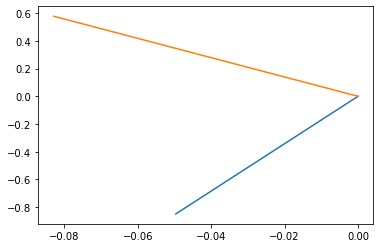

In [43]:
plt.plot([0,h[0]], [0, h[1]])
plt.plot([0,e[0]], [0, e[1]])

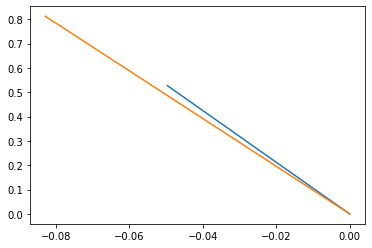

In [44]:
plt.plot([0,h[0]], [0, h[2]])
plt.plot([0,e[0]], [0, e[2]])

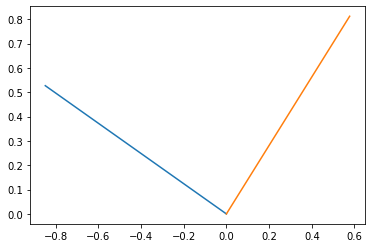

In [45]:
plt.plot([0,h[1]], [0, h[2]])
plt.plot([0,e[1]], [0, e[2]])